# Self-Driving Car Engineer Nanodegree

## Project: Behavior Cloning

---
## Step 0 : Utility function definition

In [1]:
import csv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sklearn

In [2]:
def load_data(log_path,image_path):
    lines = []
    with open(log_path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    
    images = []
    measurements = []
    
    for line in lines:
        source_path = line[0]
        filename = source_path.split('/')[-1]
      
        center_img_filename = line[0].split('/')[-1]
        left_img_filename = line[1].split('/')[-1]
        right_img_filename = line[2].split('/')[-1]

        img_center = cv2.imread(image_path + center_img_filename)
        img_left = cv2.imread(image_path + left_img_filename)
        img_right = cv2.imread(image_path + right_img_filename)        
        
        steering_center = float(line[3])
        correction = 0.2 
        steering_left = steering_center + correction
        steering_right = steering_center - correction
        
        images.extend([img_center, img_left, img_right])
        measurements.extend([steering_center, steering_left, steering_right])           

    return images, measurements

In [3]:
def flip_data(images, measurements):
    flip_images = []
    flip_measurements = []
    for image, measurement in zip(images,measurements):
        flip_images.append(np.fliplr(image))
        flip_measurements.append(measurement*(-1))
    return flip_images, flip_measurements


In [4]:
def generator(images, measurements, batch_size=32):
    num_samples = len(images)
    while 1: 
        sklearn.utils.shuffle(images, measurements)
        for offset in range(0, num_samples, batch_size):
            batch_images = images[offset:offset+batch_size]
            batch_measurements = measurements[offset:offset+batch_size]

            tmp_images = []
            tmp_measurements = []
            for batch_image in batch_images:
                tmp_images.append(batch_image)
            for batch_measurement in batch_measurements:   
                tmp_measurements.append(batch_measurement)

            # trim image to only see section with road
            X_train = np.array(tmp_images)
            y_train = np.array(tmp_measurements)
            yield sklearn.utils.shuffle(X_train, y_train)
            

---
## Step 1: Data augmentation

In [5]:
images = []
measurements = []

In [6]:
# Clockwise lap
images_a, measurements_a = load_data('./data/clockwise/driving_log.csv','./data/clockwise/IMG/')
images.extend(images_a)
measurements.extend(measurements_a)

# Counter clockwise lap
images_b, measurements_b = load_data('./data/counter_clockwise/driving_log.csv','./data/counter_clockwise/IMG/')
images.extend(images_b)
measurements.extend(measurements_b)

# Around curve lap
images_c, measurements_c = load_data('./data/around_curve/driving_log.csv','./data/around_curve/IMG/')
images_d, measurements_d = flip_data(images_c, measurements_c)
images.extend(images_c)
measurements.extend(measurements_c)
images.extend(images_d)
measurements.extend(measurements_d)

# Recovery lap
images_e, measurements_e = load_data('./data/recovery/driving_log.csv','./data/recovery/IMG/')
images_f, measurements_f = flip_data(images_e, measurements_e)
images.extend(images_e)
measurements.extend(measurements_e)
images.extend(images_f)
measurements.extend(measurements_f)

---
## Step 2: Training model

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

from sklearn.model_selection import train_test_split
train_images, validation_images, train_measurements, validation_measurements = train_test_split(images, measurements, test_size=0.2)

train_generator = generator(train_images, train_measurements, batch_size=64)
validation_generator = generator(validation_images, validation_measurements, batch_size=64)

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_images), validation_data=validation_generator, nb_val_samples=len(validation_images), nb_epoch=5, verbose=1)

model.save('model.h5')

Using TensorFlow backend.


Epoch 1/5
35126/35126 [==============================] - 365s - loss: 0.0380 - val_loss: 0.0333

---
## Step3 : Model training performance

dict_keys(['val_loss', 'loss'])


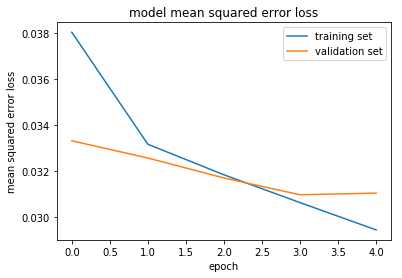

In [8]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()